In [13]:
import os
import requests
import pandas as pd
import statsmodels.api as sm
import pydlm
import numpy as np
from statsmodels.formula.api import ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from pydlm import dlm, trend, seasonality
from functools import reduce
import matplotlib.dates as mdates
import matplotlib.ticker as ticker



### Cargamos los datos

In [14]:
# Fijamos el path a los datos
PATH = '../data/raw'
os.listdir(os.path.join(PATH))

['ops.csv',
 'cuentas_un_cobro.csv',
 'apple.csv',
 'validadas.csv',
 'android.csv',
 'cuentas_un_pago.csv',
 'monto.csv']

In [15]:
# Cargamos los archivos
dfs = {}
for archivo in os.listdir(os.path.join(PATH)):
    if archivo.endswith('.csv'):
        print(archivo)
        df = pd.read_csv(os.path.join(PATH, archivo))
        df['fecha'] = pd.to_datetime(df['fecha'])
        df = df.loc[df['fecha'] >= '2024-01-01']
        df = df.rename(columns = {df.columns[1]:archivo[:-4]})
        dfs[archivo] = df

# Unimos los archivos sobre la fecha
lista_dfs = list(dfs.values())
df = reduce(lambda left, right: pd.merge(left, right, on='fecha', how='outer'), lista_dfs)
df['dispositivos']= df['apple'] + df['android']
df = df[['fecha','ops', 'monto',  'validadas', 'cuentas_un_cobro', 'cuentas_un_pago', 'dispositivos', 'android', 'apple']]


ops.csv
cuentas_un_cobro.csv
apple.csv
validadas.csv
android.csv
cuentas_un_pago.csv
monto.csv


### Cuadro con descriptivos

In [16]:
df.drop(columns=['fecha', 'apple', 'android']).describe().round(2)

,ops,monto,validadas,cuentas_un_cobro,cuentas_un_pago,dispositivos
count,477.00,477.00,477.00,477.00,477.00,477.00
mean,11504.46,12006706.96,4837.72,1031847.32,2017553.11,28642182.88
std,3477.34,6885369.72,1289.78,27854.70,171799.85,1163797.03
min,3795.00,2498308.00,206.00,973505.00,1698763.00,26477959.00
25%,9177.00,8569863.00,4014.00,1009943.00,1878691.00,27664860.00
50%,11857.00,11952633.00,4741.00,1037258.00,2026462.00,28736303.00
75%,13964.00,14130864.00,5704.00,1056708.00,2145245.00,29646065.00
max,22780.00,70196115.00,9848.00,1070218.00,2323772.00,30533240.00


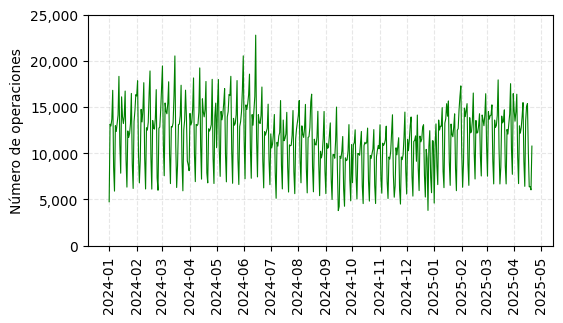

In [17]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(df['fecha'], df['ops'], label='Número de Operaciones', color='green', linewidth=0.8)

# Ticks de fecha
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)

# Títulos
ax.set_ylabel('Número de operaciones')

# Cuadricula
ax.grid(True, linestyle='--', alpha=0.3)

# Límites
ax.set_ylim(0, 25000)

# Formato de eje y
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

In [18]:
df['dow'] = df['fecha'].dt.dayofweek
dias_es = {
    'Monday': 'Lunes', 'Tuesday': 'Martes', 'Wednesday': 'Miércoles',
    'Thursday': 'Jueves', 'Friday': 'Viernes', 'Saturday': 'Sábado', 'Sunday': 'Domingo'
}
df['dow_str'] = df['fecha'].dt.strftime('%A').map(dias_es)

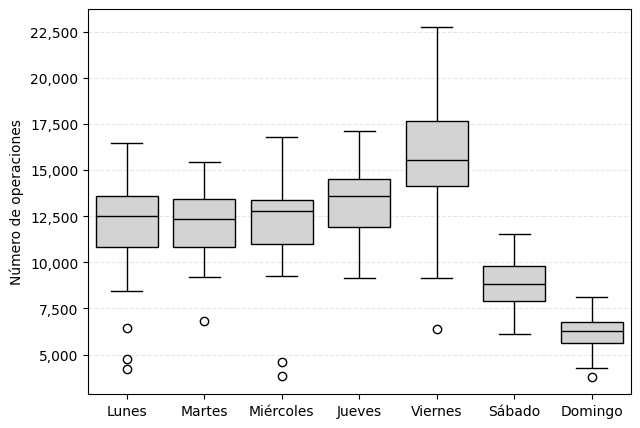

In [19]:
# Gráfica de boxplot por día de la semana
import seaborn as sns
fig, ax = plt.subplots(figsize=(7, 5)) # Medidas en pulgadas
sns.boxplot(x='dow_str', y='ops', data=df, ax=ax, order=['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'], color='lightgrey', legend = False, linecolor = 'black')
ax.set_xlabel('')
ax.set_ylabel('Número de operaciones')
ax.grid(axis='y', linestyle='--', alpha=0.3)
# Formato de eje y
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

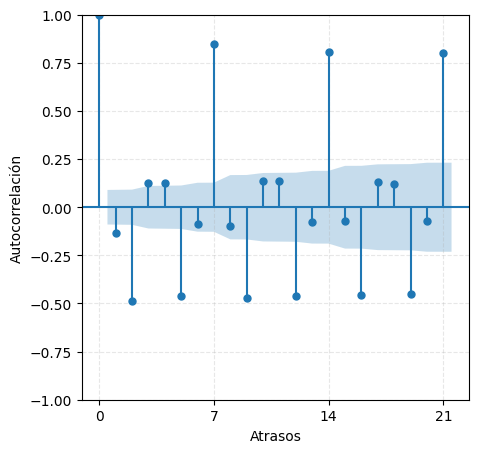

In [20]:
# Gráfica de autocorrelación
fig, ax = plt.subplots(figsize=(5, 5))
plot_acf(np.diff(df['ops']), lags=21, ax=ax)
ax.set_title('')
ax.set_xlabel('Atrasos')
ax.set_ylabel('Autocorrelación')
ax.grid(True, linestyle='--', alpha=0.3)
ax.set_xticks(np.arange(0, 22, 7))
plt.show()